# Ex3 - Part 2

## Variational Autoencoder

In [1]:
%matplotlib inline

import helper
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from functools import partial

### Consts

In [2]:
CIFAR_10_DATASET_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
CIFAR_10_DATASET_FOLDER_PATH = 'cifar-10-batches-py'
TAR_GZ_PATH = 'cifar-10-python.tar.gz'

NOISE_FACTOR = 5
N_BATCHES = 5

### Hyperparameters

In [3]:
epochs = 100
batch_size = 1000
learning_rate = 0.01

### Prepare the dataset

In [4]:
helper.download_dataset(CIFAR_10_DATASET_URL, CIFAR_10_DATASET_FOLDER_PATH, TAR_GZ_PATH) 
helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, N_BATCHES)
    
images, _ = helper.load_cfar10_batch(CIFAR_10_DATASET_FOLDER_PATH, random.randint(1, N_BATCHES))

In [5]:
plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(images[i + random.randint(0, len(images) - 10)])

### Build the network

In [6]:
# def unpool(value, name='unpool'):
#     with tf.name_scope(name) as scope:
#         sh = value.get_shape().as_list()
#         dim = len(sh[1:-1])
#         out = (tf.reshape(value, [-1] + sh[-dim:]))
#         for i in range(dim, 0, -1):
#             out = tf.concat([out, tf.zeros_like(out)], i)
#         out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
#         out = tf.reshape(out, out_size, name=scope)
#     return out

In [7]:
n_inputs = 32 * 32 * 3
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer())

X = tf.placeholder(tf.float32, (None, 32, 32, 3))

encoder = tf.layers.conv2d(X, 12, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 48, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 192, [5, 5], strides=(4, 4), padding="SAME")

flattened = tf.contrib.layers.flatten(encoder)

hidden1 = my_dense_layer(flattened, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)

# decoder = tf.layers.conv2d_transpose(hidden5, 192, [5, 5], strides=(4, 4), padding="SAME")
# decoder = unpool(decoder)
# decoder = tf.layers.conv2d_transpose(decoder, 48, [5, 5], strides=(1, 1), padding="SAME")
# decoder = unpool(decoder)
# decoder = tf.layers.conv2d_transpose(decoder, 3, [5, 5], strides=(1, 1), padding="SAME")

logits = my_dense_layer(hidden5, n_outputs, activation=None)

outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.contrib.layers.flatten(X), logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

training_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Train the network

In [8]:
sess = tf.Session()

In [9]:
print('Training...')

sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, N_BATCHES + 1):
        for features, _, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            sess.run(training_op, feed_dict={X: features})
    loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], 
                                                                  feed_dict={X: features})
    print("Epoch: {}/{}...".format(e + 1, epochs), 
          "Training loss: {:.4f}".format(loss_val), 
          "Reconstruction loss: {:.4f}".format(reconstruction_loss_val), 
          "Latent loss: {:.4f}".format(latent_loss_val))

Training...
('Epoch: 1/1...', 'Training loss: 40743.2969', 'Reconstruction loss: 40597.7852', 'Latent loss: 145.5132')


### Test the network

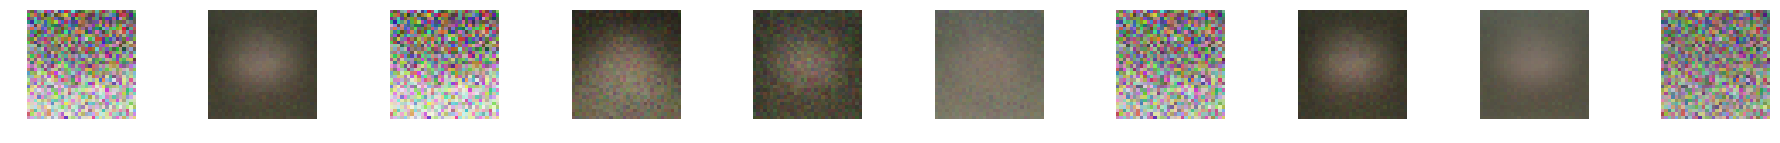

In [10]:
codings_rnd = np.random.normal(size=[10, n_hidden3])
outputs_val = outputs.eval(session=sess, feed_dict={hidden3: codings_rnd})

plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(outputs_val[i].reshape([32, 32, 3]))